In [ ]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [36]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Dropout, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
from tensorflow.keras.datasets import cifar10

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
x_train, x_test = x_train/255.0 , x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

print("x_train shape:" , x_train.shape)
print("y_train shape:" , y_train.shape)


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)


In [8]:
print(x_train[0].shape)

(32, 32, 3)


In [9]:
# number of classes

k = len(set(y_train))
print("number of classes : ", k)



number of classes :  10


In [37]:
i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3,3), activation="relu", padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation="relu", padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x) 
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x) 
x = Dropout(0.3)(x)

x = Conv2D(128, (3,3), activation="relu", padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation="relu", padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x) 
x = Dropout(0.4)(x)

x = Conv2D(256, (3,3), activation="relu", padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), activation="relu", padding = "same")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(k, activation="softmax")(x)

model = Model(i,x)

In [39]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics= ["accuracy"])
batch_size = 64
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit(train_generator, validation_data =(x_test, y_test), steps_per_epoch = steps_per_epoch, epochs = 200)

Epoch 1/200
781/781 [==============================] - 34s 42ms/step - loss: 0.8638 - accuracy: 0.7163 - val_loss: 0.7876 - val_accuracy: 0.7431
Epoch 2/200
781/781 [==============================] - 31s 40ms/step - loss: 0.8009 - accuracy: 0.7354 - val_loss: 0.7024 - val_accuracy: 0.7730
Epoch 3/200
781/781 [==============================] - 31s 39ms/step - loss: 0.7539 - accuracy: 0.7505 - val_loss: 0.7198 - val_accuracy: 0.7617
Epoch 4/200
781/781 [==============================] - 30s 39ms/step - loss: 0.7100 - accuracy: 0.7672 - val_loss: 0.6756 - val_accuracy: 0.7764
Epoch 5/200
781/781 [==============================] - 30s 39ms/step - loss: 0.6815 - accuracy: 0.7739 - val_loss: 0.8321 - val_accuracy: 0.7382
Epoch 6/200
781/781 [==============================] - 31s 40ms/step - loss: 0.6533 - accuracy: 0.7819 - val_loss: 0.6148 - val_accuracy: 0.8008
Epoch 7/200
781/781 [==============================] - 31s 40ms/step - loss: 0.6270 - accuracy: 0.7928 - val_loss: 0.7340 - val_ac

In [40]:
p_test = model.predict(x_test).argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


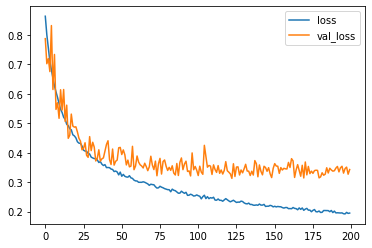

In [41]:
plt.plot(r.history["loss"], label = "loss")
plt.plot(r.history["val_loss"], label = "val_loss")
plt.legend()

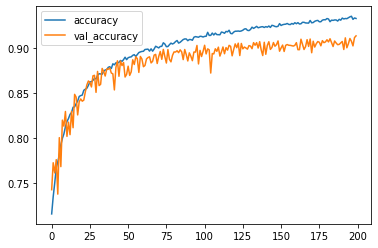

In [42]:
plt.plot(r.history["accuracy"], label = "accuracy")
plt.plot(r.history["val_accuracy"], label = "val_accuracy")
plt.legend()

In [43]:
label = '''
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()


Text(0.5, 1.0, 'True label : bird,  Predicted label : cat')

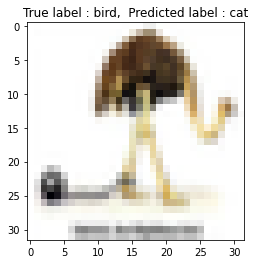

In [44]:
misclass = np.where(p_test != y_test)[0]
i = np.random.choice(misclass)
plt.imshow(x_test[i], cmap = "gray")
plt.title("True label : %s,  Predicted label : %s" % (label[y_test[i]], label[p_test[i]]))